##Build a basic chatbot with LangGraph(Graph API)

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [3]:
class State(TypedDict):
    # Messages have the type "list". The 'add_messages' function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than  overwriting them)
    messages: Annotated[list, add_messages]
    


In [4]:
# graph_builder

In [5]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [6]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model 

llm=ChatGroq(model="llama3-8b-8192")

In [7]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002108D2DCAD0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002108D2DD6A0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [8]:
##Node Functionality
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [9]:
graph_builder=StateGraph(State)
## Adding node
graph_builder.add_node("llmchatbot",chatbot)
## Adding edges
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)
##COMPILE GRAPH
graph = graph_builder.compile()

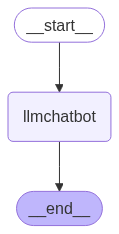

In [10]:
## Visualize the graph
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except exception:
    pass

In [11]:
response = graph.invoke({"messages":"Hi"})

In [12]:
response["messages"][-1].content

"Hi! It's nice to meet you. Is there something I can help you with, or would you like to chat?"

In [13]:
for event in graph.stream({"messages":"Hi How are you"}):
    # print(event)
    for value in event.values():
        print(value["messages"][-1].content)

I'm just a language model, I don't have feelings like humans do, but I'm functioning properly and ready to help you with any questions or tasks you may have! How about you? How's your day going?


Chatbot with tools

In [14]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tool.invoke("what is langgraph")

{'query': 'what is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interaction

## Custom Function


In [15]:
def multiply(a:int,b:int)->int:
    """Multiply a and b
    
    Args: 
        a (int): first int
        b (int): second int
    
    Returns:
        int : output int 
    """
    return a*b

In [16]:
tools = [tool,multiply]

In [17]:
llm_with_tool = llm.bind_tools(tools)

In [18]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002108D2DCAD0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002108D2DD6A0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list 

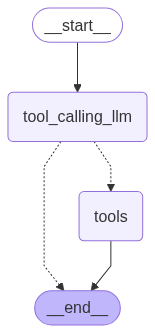

In [19]:
# stategraph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is NOT a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)

## compile the graph
graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))



In [20]:
response = graph.invoke({"messages":"What is the recent AI news"})

In [21]:
response['messages'][-1].content

'{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://sustainablebrands.com/read/biomimicry-framework-ethical-ai", "title": "Biomimicry: A Promising New Framework for Ethical AI - Sustainable Brands", "score": 0.6546525, "published_date": "Wed, 06 Aug 2025 12:00:00 GMT", "content": "The use of generative AI has expanded rapidly in recent years — with Large Language Models (LLMs) by companies including OpenAI, Meta and Google becoming household names. OpenAI’s ChatGPT service alone receives around one billion queries each day. [...] The UA study argues many of the cons of AI could be addressed through a more intentional, “ecological” approach to designing AI systems and how they interact with users. It builds on recent research from University College London and UNESCO, which highlights simple changes to how LLMs perform calculations that could significantly reduce its energy and resource demand at scale. [...] Each generati

In [22]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent AI news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (hvrfq1xs5)
 Call ID: hvrfq1xs5
  Args:
    query: recent AI news
    search_depth: advanced
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://sustainablebrands.com/read/biomimicry-framework-ethical-ai", "title": "Biomimicry: A Promising New Framework for Ethical AI - Sustainable Brands", "score": 0.6546525, "published_date": "Wed, 06 Aug 2025 12:00:00 GMT", "content": "The use of generative AI has expanded rapidly in recent years — with Large Language Models (LLMs) by companies including OpenAI, Meta and Google becoming household names. OpenAI’s ChatGPT service alone rec

In [23]:
response = graph.invoke({"messages":"What is 2 multiplied by 3"})
response['messages'][-1].content
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 multiplied by 3
================================== Ai Message ==================================
Tool Calls:
  multiply (j9h0wdt9q)
 Call ID: j9h0wdt9q
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [24]:
# response = graph.invoke({"messages":"What is 2 multiplied by 3 and then multiply by 10"})
response = graph.invoke({"messages":"What is the recentAI news and then multiply 2 by 3"})
# response['messages'][-1].content
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recentAI news and then multiply 2 by 3
================================== Ai Message ==================================
Tool Calls:
  tavily_search (v88b2e545)
 Call ID: v88b2e545
  Args:
    query: recent AI news
    search_depth: advanced
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://opentools.ai/news/nasas-spacex-crew-11-makes-a-stellar-splash-at-the-iss", "title": "NASA's SpaceX Crew-11 Makes a Stellar Splash at the ISS! - OpenTools", "score": 0.8409005, "published_date": "Sun, 03 Aug 2025 09:12:52 GMT", "content": "Latest AI News: Daily Updated Artificial Intelligence Insights (August 3, 2025)\n\n===============\n\nOpenToolsImage 1: logo\n\nOpen main menu\n\nNewsletterNewsSubmit A ToolAdvertise\n\nCatego

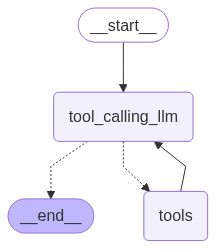

In [25]:
### ReAct Agent architecture -> Act, Observe, Reason
# stategraph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is NOT a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))



In [27]:
response = graph.invoke({"messages":"What is the recent AI news and then multiply 2 by 3"})
# response['messages'][-1].content
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent AI news and then multiply 2 by 3
================================== Ai Message ==================================
Tool Calls:
  tavily_search (we1yqrqa3)
 Call ID: we1yqrqa3
  Args:
    query: AI news
    search_depth: advanced
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://opentools.ai/news/nasas-spacex-crew-11-makes-a-stellar-splash-at-the-iss", "title": "NASA's SpaceX Crew-11 Makes a Stellar Splash at the ISS! - OpenTools", "score": 0.8066246, "published_date": "Sun, 03 Aug 2025 09:12:52 GMT", "content": "Latest AI News: Daily Updated Artificial Intelligence Insights (August 3, 2025)\n\n===============\n\nOpenToolsImage 1: logo\n\nOpen main menu\n\nNewsletterNewsSubmit A ToolAdvertise\n\nCategories\n\nGet s

Adding memory in Agentic graph

In [31]:
response = graph.invoke({"messages":"Hello my name is Sowmya"})
# response['messages'][-1].content
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello my name is Sowmya
================================== Ai Message ==================================

Nice to meet you, Sowmya! What brings you here today?


In [33]:
response = graph.invoke({"messages":"what is my name"})
# response['messages'][-1].content
for m in response['messages']:
    m.pretty_print()

BadRequestError: Error code: 400 - {'error': {'message': "tool call validation failed: parameters for tool multiply did not match schema: errors: [missing properties: 'a', 'b']", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<tool-use>\n{\n    "tool_call": {\n        "id": "pending",\n        "type": "function",\n        "function": {\n            "name": "multiply",\n            "parameters": {\n                "a": "what",\n                "b": "is"\n            }\n        },\n        "parameters": {\n            "properties": {\n                "query": "what is my name",\n                "topic": "general"\n            },\n            "required": [\n                "query"\n            ],\n            "type": "object"\n        }\n    }\n}\n</tool-use>'}}

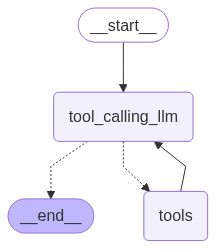

In [34]:
### Adding memory
### ReAct Agent architecture -> Act, Observe, Reason
# stategraph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is NOT a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))



In [35]:
config={"configurable":{"thread_id":"1"}}

response = graph.invoke({"messages":"Hi my name is Krish"},config=config)
response

{'messages': [HumanMessage(content='Hi my name is Krish', additional_kwargs={}, response_metadata={}, id='f93050f6-d8d5-471e-bcbb-50c09c037c60'),
  AIMessage(content='Nice to meet you, Krish! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 2867, 'total_tokens': 2882, 'completion_time': 0.016813597, 'prompt_time': 0.317578174, 'queue_time': 0.057464247, 'total_time': 0.334391771}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_5b339000ab', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--e5c97326-d47f-4b70-8511-7e97926d3560-0', usage_metadata={'input_tokens': 2867, 'output_tokens': 15, 'total_tokens': 2882})]}

In [36]:
# response = graph.invoke({"messages":"what is my name"})
response['messages'][-1].content
# for m in response['messages']:
#     m.pretty_print()

'Nice to meet you, Krish! How can I assist you today?'

In [37]:
response = graph.invoke({"messages":"Hi what is my name"},config=config)
print(response['messages'][-1].content)

Your name is Krish!


In [38]:
response = graph.invoke({"messages":"Hi do you remember my name"},config=config)
print(response['messages'][-1].content)

Yes, I remember your name is Krish!


# Streaming

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [39]:
def superbot(state:State):
    return {"messages":[llm.invoke(state['messages'])]}